In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import fmin
import time
from decimal import *

In [2]:
class Model:

    def __init__(self,rstar,bet,sig,alp,the,ome,kap,lam,rhou,rhog,sigu,sigg,Nu,Ng,maxiter,tol):
        
        self.rstar = rstar     # pH=0のときの、定常状態での名目金利の値
        self.bet = bet         # 割引率(オイラー方程式の定常状態より)
        self.sig = sig         # Real rate elasticity of output
        self.alp = alp         # Share of firms keeping prices fixed
        self.the = the         # Price elasticity of demand
        self.ome = ome         # Elasticity of firms' marginal costs
        self.kap = kap         # Slope of the Phillips curve
        self.lam = lam         # Weight on output in the loss function
        self.rhou = rhou       # AR-coefficient mark-up shocks
        self.rhog = rhog       # AR-coefficient real rate shocks
        self.sigu = sigu       # S.d. mark-up shock innovations
        self.sigg = sigg       # S.d. real rate shock innovations
        self.Nu = Nu           # Number of mark-up shock grids
        self.Ng = Ng           # Number of real rate shock grids
        self.maxiter = maxiter # 繰り返し回数の最大値
        self.tol = tol         # 許容誤差

In [3]:
def tauchen(N,mu,rho,sigma,m):
    """
    ---------------------------------------------------
    === AR(1)過程をtauchenの手法によって離散化する関数 ===
    ---------------------------------------------------
    ※z'=(1-ρ)μ + ρ*z + ε, ε~N(0,σ_{ε}^2) を離散化する

    <input>
    ・N: 離散化するグリッドの数
    ・mu: AR(1)過程の定数項(上式のμ)
    ・rho: AR(1)過程の慣性(上式のρ)
    ・sigma: AR(1)過程のショック項の標準偏差(上式のσ_{ε})
    ・m: 離散化するグリッドの範囲に関するパラメータ
    <output>
    ・Z: 離散化されたグリッド
    ・Zprob: 各グリッドの遷移行列
    """
    Zprob = np.zeros((N,N)) # 遷移確率の行列
    c = (1-rho)*mu # 定数項

    # 等間隔のグリッドを定める
    # 最大値と最小値
    zmax = m*np.sqrt(sigma**2/(1-rho**2))
    zmin = -zmax
    # グリッド間の間隔
    w = (zmax-zmin)/(N-1)

    Z = np.linspace(zmin,zmax,N)
    # 定常状態はmu(E[Z]=mu)
    Z += mu

    # グリッド所与として遷移確率を求める
    for j in range(N): # 今期のZのインデックス
        for k in range(N): # 来期のZのインデックス
            if k == 0: # Pythonのインデックスは0から始まる(ここでは0からN-1)
                Zprob[j,k] = cdf_normal((Z[k]-c-rho*Z[j]+w/2)/sigma)
            elif k == N-1:
                Zprob[j,k] = 1 - cdf_normal((Z[k]-c-rho*Z[j]-w/2)/sigma)
            else:
                Zprob[j,k] = cdf_normal((Z[k]-c-rho*Z[j]+w/2)/sigma) - cdf_normal((Z[k]-c-rho*Z[j]-w/2)/sigma)

    return Z,Zprob 

In [4]:
def cdf_normal(x):
    """
    --------------------------------
    === 標準正規分布の累積分布関数 ===
    --------------------------------
    <input>
    ・x: 
    <output>
    ・c: 標準正規分布にしたがう確率変数Xがx以下である確率
    """
    c = stats.norm.cdf(x,loc=0,scale=1)

    return c

In [9]:
def ti(m):
    """
    ---------------------------------------
    === 時間反復法によってモデルを解く関数 ===
    ---------------------------------------
    <input>
    ・m: パラメータを含むコンストラクタ
    <ouutput>
    ・yvec0: 均衡での生産ギャップ
    ・pvec0: 均衡でのインフレ率
    ・rvec0: 均衡での名目金利
    ・Gg: 実質金利ショックのグリッド
    ・Gu: マークアップショックのグリッド
    """

    # STEP 1(a): グリッド生成
    Gg, Pg = tauchen(m.Ng,m.sig*m.rstar,m.rhog,m.sigg,3.0)
    Gu, Pu = tauchen(m.Nu,0.0,m.rhou,m.sigu,3.0)

    # 2次元グリッドの座標(g,u)を1次元のベクトルに集約する
    Ns = m.Ng*m.Nu
    Gs = np.zeros((Ns,2))

    for ig in range(m.Ng):
        for iu in range(m.Nu):

            Gs[m.Nu*ig+iu,0] = Gg[ig]
            Gs[m.Nu*ig+iu,1] = Gu[iu]

    # 2のショックの遷移確率を下に同時分布の遷移行列を計算する
    Ps = np.kron(Pg,Pu)

    # STEP 1(b): 政策関数の初期値を当て推量
    # 適当な初期値
    yvec0 = np.zeros(Ns)
    pvec0 = np.zeros(Ns)
    rvec0 = np.zeros(Ns)
    yvec1 = np.zeros(Ns)
    pvec1 = np.zeros(Ns)
    rvec1 = np.zeros(Ns)

    # STEP 4: 政策関数を繰り返し計算
    diff = 1e+4 # 政策関数の繰り返し誤差
    iter = 1 # ループ・カウンター

    while diff > m.tol:
        
        for iss in range(Ns): # Pythonではループにおけるインデックスをissにしている

            # ショックの値
            g0 = Gs[iss,0]
            u0 = Gs[iss,1]

            # 古い政策関数から期待値(ye,pie)を計算
            ye = Ps[iss,:].T @ yvec0
            pie = Ps[iss,:].T @ pvec0

            # 期待値を所与として最適化
            p0 = (m.bet*pie+u0)/(1+(m.kap**2/m.lam))
            y0 = (-m.kap/m.lam)*p0
            r0 = (1/m.sig)*(ye-y0+g0) + pie

            if r0 < 0:

                y0 = ye - m.sig*(0-pie) + g0;
                p0 = m.kap*y0 + m.bet*pie + u0;
                r0 = 0.0
            
            # 新しい政策関数を保存
            yvec1[iss] = y0
            pvec1[iss] = p0
            rvec1[iss] = r0

        # 繰り返し計算誤差を確認
        ydiff = np.max(abs(yvec1-yvec0))
        pdiff = np.max(abs(pvec1-pvec0))
        rdiff = np.max(abs(rvec1-rvec0))
        diff = max(ydiff, pdiff, rdiff)

        #print([iter, diff])

        # 政策関数をアップデート
        yvec0 = np.copy(yvec1)
        pvec0 = np.copy(pvec1)
        rvec0 = np.copy(rvec1)

        iter += 1
    
    return yvec0, pvec0, rvec0, Gg, Gu

In [10]:
# カリブレーション
rstar = 3.5/4 # pH=0のときの、定常状態での名目金利の値
bet = 1/(1+rstar/100) # 割引率(オイラー方程式の定常状態より)
sig = 6.25 # Real rate elasticity of output
alp = 0.66 # Share of firms keeping prices fixed
the = 7.66 # Price elasticity of demand
ome = 0.47 # Elasticity of firms' marginal costs
kap = (1-alp)*(1-alp*bet)/alp*(1/sig+ome)/(1+ome*the) # Slope of the Phillips curve(=0.024)
lam = 0.048/16 # Weight on output in the loss function

rhou = 0.0 # AR-coefficient mark-up shocks
rhog = 0.8 # AR-coefficient real rate shocks
sigu = 0.154 # S.d. mark-up shock innovations
sigg = 1.524 # S.d. real rate shock innovations
Ng = 31 # Number of mark-up shock grids
Nu = 31 # Number of real rate shock grids

maxiter = 2000 # 繰り返し回数の最大値
tol = 1e-5 # 許容誤差

# 構造体にパラメータを格納
m = Model(rstar,bet,sig,alp,the,ome,kap,lam,rhou,rhog,sigu,sigg,Ng,Nu,maxiter,tol)

In [61]:
# 数値解を計算する
start = time.time()
yvec0, pvec0, rvec0, Gg, Gu = ti(m)
end = time.time()
print(f"{end-start:.6f} second")

# 論文中の図4-5をレプリケートする
ymat0 = np.zeros((m.Ng,m.Nu))
pmat0 = np.empty_like(ymat0)
rmat0 = np.empty_like(ymat0)

for ig in range(m.Ng):
    for iu in range(m.Nu):

        ymat0[ig,iu] = yvec0[m.Nu*ig+iu]
        pmat0[ig,iu] = pvec0[m.Nu*ig+iu]
        rmat0[ig,iu] = rvec0[m.Nu*ig+iu]

# プロットを行うための準備
idu = int(Decimal(m.Nu/2).quantize(Decimal("0"), rounding = ROUND_CEILING)) # gについてのプロットを行う場合uはiduのインデックスで固定する
edg = int(Decimal(m.Ng/2).quantize(Decimal("0"), rounding = ROUND_CEILING)) # uについてのプロットを行う場合gはidgのインデックスで固定する 

0.823002 second


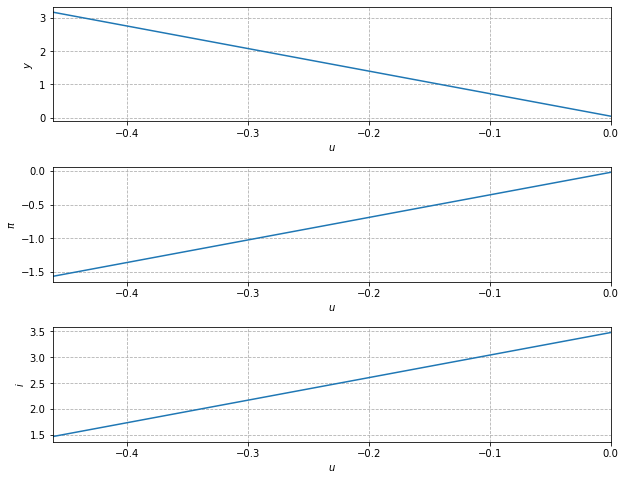

In [86]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
fig.subplots_adjust(hspace=0.4)
ax[0].plot(Gu[0:idu],ymat0[edg-1,0:idu])
ax[0].set(xlabel=r"$u$", ylabel=r"$y$",xlim=(Gu[0],Gu[idu-1]))
ax[0].grid(ls="--")

ax[1].plot(Gu[0:idu],4*pmat0[edg-1,0:idu])
ax[1].set(xlabel=r"$u$", ylabel=r"$\pi$",xlim=(Gu[0],Gu[idu-1]))
ax[1].grid(ls="--")

ax[2].plot(Gu[0:idu],4*rmat0[edg-1,0:idu])
ax[2].set(xlabel=r"$u$", ylabel=r"$i$",xlim=(Gu[0],Gu[idu-1]))
ax[2].grid(ls="--")

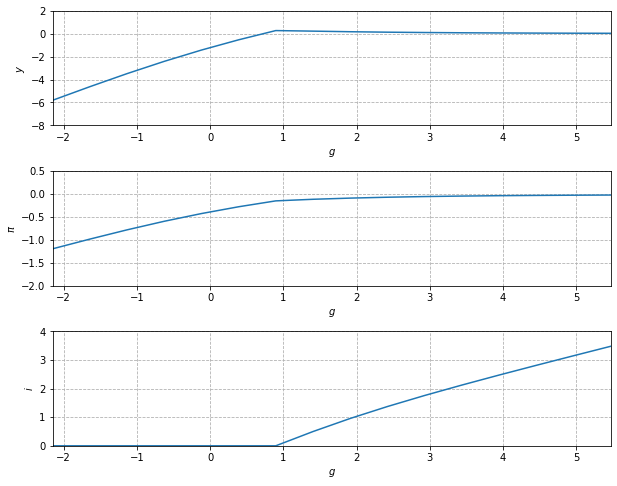

In [82]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
fig.subplots_adjust(hspace=0.4)
ax[0].plot(Gg[0:edg],ymat0[0:edg,idu-1])
ax[0].set(xlabel=r"$g$", ylabel=r"$y$",xlim=(Gg[0],Gg[edg-1]),ylim=(-8,2))
ax[0].grid(ls="--")

ax[1].plot(Gg[0:edg],4*pmat0[0:edg,idu-1])
ax[1].set(xlabel=r"$g$", ylabel=r"$\pi$",xlim=(Gg[0],Gg[edg-1]),ylim=(-2,0.5))
ax[1].grid(ls="--")

ax[2].plot(Gg[0:edg],4*rmat0[0:edg,idu-1])
ax[2].set(xlabel=r"$g$", ylabel=r"$i$",xlim=(Gg[0],Gg[edg-1]),ylim=(0,4))
ax[2].grid(ls="--")